In [22]:
###-----------------
### Import Libraries
###-----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import torch
import torch.nn as nn



In [23]:
###----------------
# Global Variables
###----------------


TEST_SIZE = 0.2
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)


N_SAMPLES = 1000
NOISE = 0.2
ALPHA = 0.001
EPOCHS = 2000

# set location of input files and output files
inpDir = '../input'
outDir = '../output'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

In [24]:
###-----------------------------------------------------------
### Function to plot Loss Curve using Tensorflow history object
###------------------------------------------------------------

def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(), 
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


---
$$
\textbf{Make Moon Dataset}
$$

In [25]:
X,y = datasets.make_moons(
        n_samples = N_SAMPLES,
        noise = NOISE,
        shuffle  = True,
        random_state = RANDOM_STATE
)
X.shape, y.shape

((1000, 2), (1000,))

<Axes: xlabel='A', ylabel='B'>

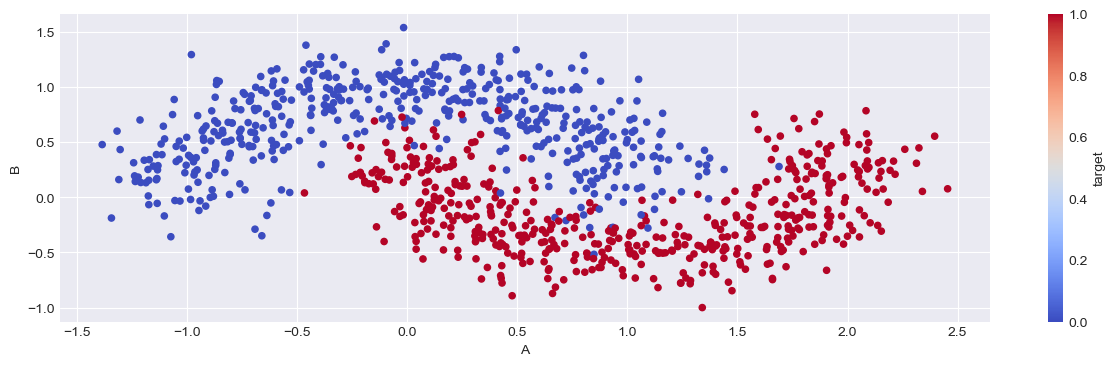

In [26]:
data_df = pd.DataFrame(X, columns = ('A','B'))
data_df['target'] = y
data_df.head()

data_df.plot.scatter('A','B',c= 'target', cmap=CMAP)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,stratify = y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [28]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
input_dim = X_test.shape[1] 


model = nn.Sequential(
    nn.Linear(input_dim, 5),    nn.ReLU(),
    nn.Linear(5, 5),            nn.ReLU(),
    nn.Linear(5, 4),            nn.ReLU(),
    nn.Linear(4, 3),            nn.ReLU(),  
    nn.Linear(3, 2)
).to(device=device)

model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): ReLU()
  (8): Linear(in_features=3, out_features=2, bias=True)
)

In [30]:
train_X = torch.tensor(X_train, dtype=torch.float32).to(device=device)
train_y = torch.tensor(y_train, dtype=torch.int64).to(device=device)
test_X = torch.tensor(X_test, dtype=torch.float32).to(device=device)
test_y = torch.tensor(y_test, dtype=torch.int64).to(device=device)

In [31]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

for epoch in range(EPOCHS):
    model.train()
    precit_proba = model(train_X)
    curr_loss = loss_fn(precit_proba, train_y)
    # Back propagation
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    


In [32]:
output =  model(train_X)
y_pred = torch.argmax(output, dim=1).cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    train_y.cpu().numpy(),
    y_pred
))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       400
           1       0.96      0.96      0.96       400

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



In [46]:
# Adding Some Tracing to it
del model
input_dim = X_test.shape[1] 


model = nn.Sequential(
    nn.Linear(input_dim, 5),    nn.ReLU(),
    nn.Linear(5, 5),            nn.ReLU(),
    nn.Linear(5, 4),            nn.ReLU(),
    nn.Linear(4, 3),            nn.ReLU(),  
    nn.Linear(3, 2)
).to(device=device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

loss = []
tloss = []
n_epoch = []
accuracy = []
taccuracy = []

for epoch in range(EPOCHS):
    model.train()
    predict_proba = model(train_X)
    curr_loss = loss_fn(predict_proba, train_y)
    # Back propagation
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()

    loss.append(curr_loss.item())

    y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()
    curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    accuracy.append(curr_acc)

    model.eval()

    test_proba = model(test_X)
    test_loss = loss_fn(test_proba, test_y)
    tloss.append(test_loss.data.item())
    
    y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
    test_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
    taccuracy.append(curr_acc)

    n_epoch.append(epoch)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:>5d} | Loss: {curr_loss:.3f}/{test_loss:.3f} | Accuracy: {curr_acc*100:.2f}/{test_acc*100:.2f}')   



Epoch:   100 | Loss: 0.687/0.686 | Accuracy: 50.00/50.00
Epoch:   200 | Loss: 0.597/0.589 | Accuracy: 78.25/79.00
Epoch:   300 | Loss: 0.375/0.363 | Accuracy: 84.75/87.00
Epoch:   400 | Loss: 0.285/0.273 | Accuracy: 86.50/88.00
Epoch:   500 | Loss: 0.261/0.243 | Accuracy: 87.62/89.00
Epoch:   600 | Loss: 0.230/0.207 | Accuracy: 91.25/92.50
Epoch:   700 | Loss: 0.164/0.136 | Accuracy: 94.00/93.50
Epoch:   800 | Loss: 0.119/0.092 | Accuracy: 95.62/95.00
Epoch:   900 | Loss: 0.103/0.077 | Accuracy: 95.75/97.00
Epoch:  1000 | Loss: 0.098/0.074 | Accuracy: 96.00/97.00
Epoch:  1100 | Loss: 0.095/0.072 | Accuracy: 96.00/97.00
Epoch:  1200 | Loss: 0.093/0.072 | Accuracy: 95.88/97.00
Epoch:  1300 | Loss: 0.091/0.072 | Accuracy: 95.88/97.50
Epoch:  1400 | Loss: 0.090/0.071 | Accuracy: 95.88/97.50
Epoch:  1500 | Loss: 0.090/0.072 | Accuracy: 95.88/97.50
Epoch:  1600 | Loss: 0.089/0.072 | Accuracy: 95.88/97.50
Epoch:  1700 | Loss: 0.089/0.073 | Accuracy: 95.75/97.50
Epoch:  1800 | Loss: 0.088/0.07

In [47]:
len(n_epoch), len(loss), len(tloss), len(accuracy), len(taccuracy)

(2000, 2000, 2000, 2000, 2000)

In [48]:
type(n_epoch), type(loss), type(tloss), type(accuracy), type(taccuracy)

(list, list, list, list, list)

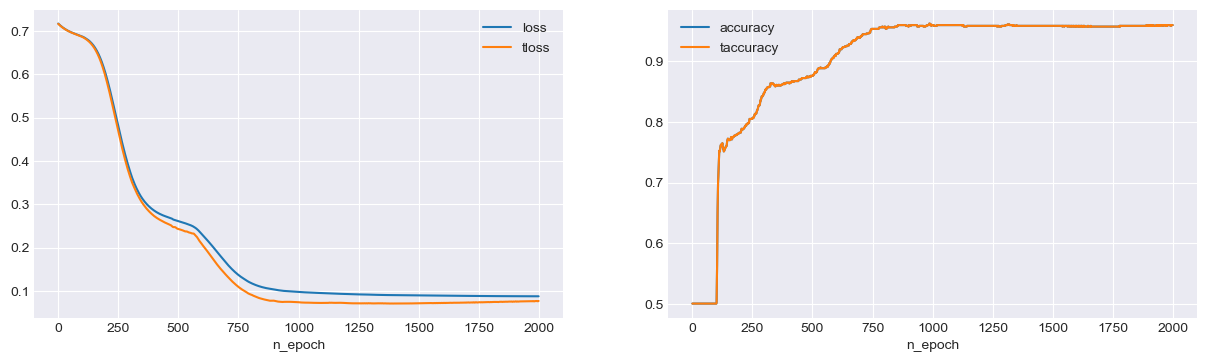

In [53]:
history = pd.DataFrame({
    'n_epoch' :n_epoch,
    'loss' :loss,
    'tloss' :tloss,
    'accuracy' :accuracy,
    'taccuracy' :taccuracy,
})



fig, axes = plt.subplots(1,2)
history.plot(x='n_epoch', y=['loss', 'tloss'], ax= axes[0])
history.plot(x='n_epoch', y=['accuracy', 'taccuracy'] , ax = axes[1])
plt.show()
